# Multi-scale Gene Regulation Inference and Analysis with scMagnify

### Preliminaries

In this tutorial, you will learn how to:

* **Multi-scale Gene Regulation Inference.** scMagnify builds upon **nonlinear multivariable Granger causal inference**, implemented through an interpretable multi-scale neural network.
* **Key Regulators Characterization.** Identify critical regulators by first performing **Regulatory Activity Inference** to estimate TF activities, and then using **Network Score Calculation** (based on graph theory) to rank their importance in the network.

See our [manuscript]() for more details.

### Input

scMagnify uses two types of input data during the regulation inference.

-   Input data 1: **scRNA-seq data.** Please look at the previous section to learn about the scRNA-seq data preprocessing and cell state dynamics analysis.
-   Input data 2: **TF Binding Network.** The TF binding network represents the TF-TG connections. The data structure is a binary 2D matrix or linklist. You can construct the binary network following our workflow, or alternatively, provide a custom one.

### GRNMuData

The `GRNMuData` class extends the `MuData` class to incorporate Gene Regulatory Networks (GRNs) and associated analysis results. Additionally, it provides a set of functions for network pruning and object conversion. Subsequent analyses will be based on this object.

:::seealso
    For a detailed explanation of the model architecture and the theory behind our Multi-scale Neural Granger Causality (MSNGC) framework, please refer to the **[About the scMagnify](./About the MSNGC.md)** section.
    :::

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
from numba.core.errors import NumbaDeprecationWarning
warnings.simplefilter("ignore", category=NumbaDeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [3]:
import os
import sys
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import scanpy as sc

In [5]:
import scmagnify as scm
import scmagnify.logging as logg
from scmagnify.settings import settings


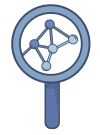

In [6]:
scm.info()

## Configurations

In [5]:
scm.settings.verbosity = 2

In [6]:
%matplotlib inline

scm.settings.set_figure_params(
    dpi=100,
    facecolor="white",
    frameon=False,
) 

scm.load_fonts(["Arial"])

plt.rcParams["font.family"] = "Arial"
plt.rcParams['grid.alpha'] = 0

In [7]:
# Setting a workspace
dirPjtHome = "/mnt/TrueNas/project/chenxufeng/Data/PMID36973557_NatBiotechnol2023_T-cell-depleted/"
workDir = os.path.join(dirPjtHome, "scmagnify_wd")
scm.set_workspace(workDir)

workspace: /mnt/TrueNas/project/chenxufeng/Data/PMID36973557_NatBiotechnol2023_T-cell-depleted/scmagnify_wd/
├── data
├── models
├── tmpfiles
└── figures

In [8]:
# Set up Reference Genome
scm.set_genome(
    version="hg38",
    genomes_dir="/home/chenxufeng/picb_cxf/Ref/human/hg38/"
)

                        Genome Information                        
┏━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Version ┃ Provider ┃ Directory                                 ┃
┡━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ hg38    │ UCSC     │ /home/chenxufeng/picb_cxf/Ref/human/hg38/ │
└─────────┴──────────┴───────────────────────────────────────────┘

## Load the data

In [11]:
mdata = scm.read(os.path.join(scm.settings.data_dir, "t-cell-depleted-bm_NaiveB_H11CORE_02.h5mu"))

In [12]:
mdata

MuData object with n_obs × n_vars = 1374 × 233703
  uns:	'motif_scan', 'peak_gene_corrs'
  obsm:	'cell_state_masks'
  2 modalities
    ATAC:	1374 x 216477
      obs:	'sample', 'celltype', 'TSSEnrichment', 'NucleosomeRatio', 'nFrags', 'BlacklistRatio', 'SEACell'
      var:	'seqnames', 'start', 'end', 'strand', 'GC', 'Bcells_primed', 'Bcells_lineage_specific'
      uns:	'celltype_colors', 'neighbors', 'peak_seq', 'sample_colors', 'umap'
      obsm:	'DM_EigenVectors', 'GeneScores', 'X_svd', 'X_umap'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    RNA:	1374 x 17226
      obs:	'sample', 'celltype', 'palantir_pseudotime', 'macrostates_fwd', 'term_states_fwd', 'term_states_fwd_probs', 'clusters_gradients', 'init_states_fwd', 'init_states_fwd_probs', 'n_counts', 'SEACell'
      var:	'highly_variable', 'significant_genes', 'means', 'dispersions', 'dispersions_norm'
      uns:	'T_fwd_params', 'celltype_colors', 'clusters_gradients_colors', 'coarse_fwd', 'eigendecomposition_fwd', 'hvg', 'init_states_fwd_colors', 'log1p', 'macrostates_fwd_colors', 'neighbors', 'sample_colors', 'schur_matrix_fwd', 'term_states_fwd_colors', 'test_assoc', 'umap'
      obsm:	'T_fwd_umap', 'X_FDL', 'X_fate_simplex_fwd', 'X_pca', 'X_umap', 'cell_state_masks', 'cellrank_fate_probabilities', 'init_states_fwd_memberships', 'lineages_fwd', 'macrostates_fwd_memberships', 'schur_vectors_fwd'
      varm:	'test_assoc_res'
      layers:	'MAGIC_imputed_data', 'counts', 'log1p_norm'
      obsp:	'connectivities', 'distances', 'knn'

## Train the model

After preparing the scRNA-seq data and constructing the TF binding network, we are ready to infer the multi-scale GRN.

The first step is to initialize the `scm.MAGNI` model. This initialization call handles more than just setting parameters; it also performs all necessary data preprocessing based on the `mdata` object and the previously defined TF binding network:

1.  It maps the motif-based TF binding network to the genes and TFs present in the RNA expression data.
2.  It builds the chromatin constraint statistics.
3.  It normalizes the expression data from the specified `layer`.
4.  It constructs the internal data structures (like the DAG and S matrix) required by the MSNGC model.
5.  It sets up the model architecture (e.g., `hidden` layers) and moves it to the specified `device`.

In [15]:
magni = scm.MAGNI(
            mdata,
            max_iter=1000, 
            patience=10, 
            layer="log1p_norm",
            hidden=[50],
            lag=5, 
            batch_size=32,
            seed=42,
            device="cuda:1"
        )

Output()

   Chromatin Constraint Statistics   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Metric                    ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ n_cells                   │  1374 │
│ n_genes                   │ 17226 │
│ n_regulators_in_basal_GRN │   403 │
│ n_targets_in_basal_GRN    │  2927 │
│ n_regulators_in_both      │   105 │
│ n_targets_in_both         │  2928 │
└───────────────────────────┴───────┘

INFO     Normalizing data: 0 mean, 1 SD

INFO     Constructing DAG...

INFO     Constructing S matrix...

INFO     Calculating diffusion lags...

INFO     MSNGC(                                                                                                    
           (coeff_nets): ModuleList(                                                                               
             (0-4): 5 x Sequential(                                                                                
               (0): Sequential(                                                                                    
                 (0): Linear(in_features=105, out_features=50, bias=True)                                          
                 (1): ReLU()                                                                                       
               )                                                                                                   
               (1): Linear(in_features=50, out_features=307440, bias=True)                                         
             )                                                                                                     
           )                                                                                                       
           (attention): Embedding(1, 5)                                                                            
         )

In [16]:
model = magni.train()

Output()

Epoch 00056: reducing learning rate of group 0 to 5.0000e-04.

Epoch 00080: reducing learning rate of group 0 to 2.5000e-04.

Epoch 00091: reducing learning rate of group 0 to 1.2500e-04.

Epoch 00109: reducing learning rate of group 0 to 6.2500e-05.

Epoch 00120: reducing learning rate of group 0 to 3.1250e-05.

Epoch 00127: reducing learning rate of group 0 to 1.5625e-05.

Epoch 00142: reducing learning rate of group 0 to 7.8125e-06.

INFO     Early stopping at epoch 145

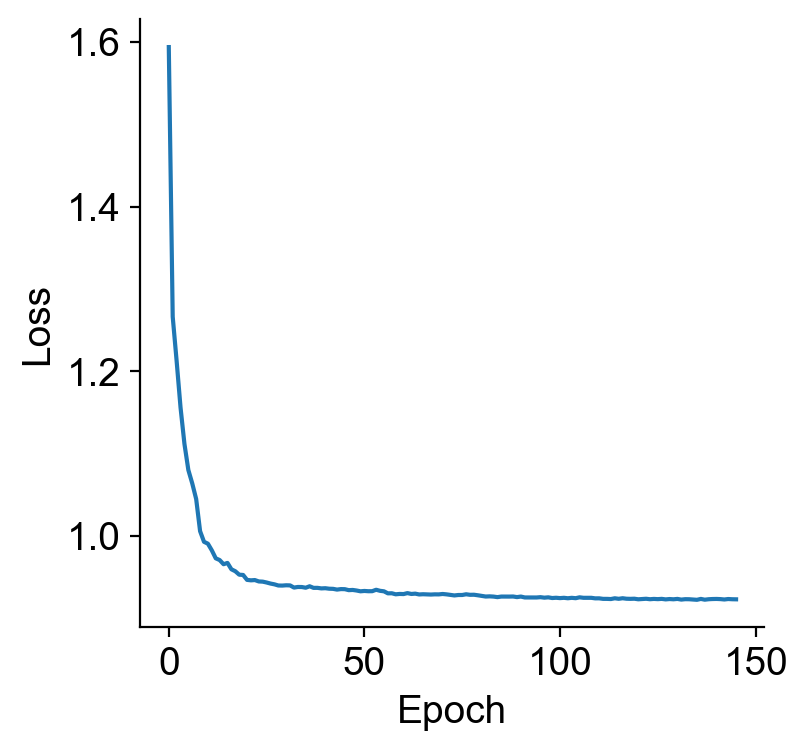

In [17]:
plt.plot(model.history["train_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [18]:
magni.save(os.path.join(settings.models_dir, "t-cell-depleted-bm_NaiveB_02_MAGNI_model.pth"))

INFO     Saving model state to                                                                                     
         /mnt/TrueNas/project/chenxufeng/Data/PMID36973557_NatBiotechnol2023_T-cell-depleted/scmagnify_wd/models/t-
         cell-depleted-bm_NaiveB_02_MAGNI_model.pth...

INFO     Model saved successfully.

## Regulation Inference

Once the model is initialized and data is preprocessed, we call the `magni.regulation_inference()` method to run the model and infer the network.

This single function executes the complete inference and post-processing pipeline:
1.  It use the trained MSNGC model to find causal relationships.
2.  It estimates time lags and formulates the initial network edges.
3.  It computes the regulatory activity for each TF.
4.  It filters the network edges based on coefficient scores (e.g., using a quantile cutoff) to prune weak or noisy connections.
5.  Finally, it bundles all results—including the filtered network, TF activities, and attention weights—into a new `GRNMuData` object for downstream analysis.

In [19]:
gdata = magni.regulation_inference()

INFO     Starting regulation inference...

INFO     Computing CV of the coefficients with 0.2...

INFO     Estimating time lags...

INFO     Formulating network edges...

INFO     Computing TF activity...

INFO     Creating GRNMuData object...

INFO     Filtering network by quantile with params 0.9...

                                 Network Filtered Statistics                                 
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Method(Param)        ┃ Attribute            ┃ Binarize             ┃ Filtered/Raw(Percen… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ quantile(0.9)        │ score                │ True                 │ 7922/79219 (0.10)    │
└──────────────────────┴──────────────────────┴──────────────────────┴──────────────────────┘

INFO     Saving attention weights...

In [21]:
gdata

Gene Regulatory Network (GRN) with 79219 edges.
MuData object with n_obs × n_vars = 1374 × 233808
  uns:	'motif_scan', 'peak_gene_corrs', 'network', 'filtered_network', 'attention_weights'
  3 modalities
    ATAC:	1374 x 216477
      obs:	'sample', 'celltype', 'TSSEnrichment', 'NucleosomeRatio', 'nFrags', 'BlacklistRatio', 'SEACell'
      var:	'seqnames', 'start', 'end', 'strand', 'GC', 'Bcells_primed', 'Bcells_lineage_specific'
      uns:	'celltype_colors', 'neighbors', 'peak_seq', 'sample_colors', 'umap'
      obsm:	'DM_EigenVectors', 'GeneScores', 'X_svd', 'X_umap'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    RNA:	1374 x 17226
      obs:	'sample', 'celltype', 'palantir_pseudotime', 'macrostates_fwd', 'term_states_fwd', 'term_states_fwd_probs', 'clusters_gradients', 'init_states_fwd', 'init_states_fwd_probs', 'n_counts', 'SEACell'
      var:	'highly_variable', 'significant_genes', 'means', 'dispersions', 'dispersions_norm'
      uns:	'T_fwd_params', 'celltype_colors', 'clusters_gradients_colors', 'coarse_fwd', 'eigendecomposition_fwd', 'hvg', 'init_states_fwd_colors', 'log1p', 'macrostates_fwd_colors', 'neighbors', 'sample_colors', 'schur_matrix_fwd', 'term_states_fwd_colors', 'test_assoc', 'umap'
      obsm:	'T_fwd_umap', 'X_FDL', 'X_fate_simplex_fwd', 'X_pca', 'X_umap', 'cell_state_masks', 'cellrank_fate_probabilities', 'init_states_fwd_memberships', 'lineages_fwd', 'macrostates_fwd_memberships', 'schur_vectors_fwd'
      varm:	'test_assoc_res'
      layers:	'MAGIC_imputed_data', 'counts', 'log1p_norm'
      obsp:	'connectivities', 'distances', 'knn'
    GRN:	1374 x 105
      obs:	'sample', 'celltype', 'palantir_pseudotime', 'macrostates_fwd', 'term_states_fwd', 'term_states_fwd_probs', 'clusters_gradients', 'init_states_fwd', 'init_states_fwd_probs', 'n_counts', 'SEACell'
      var:	'mean_activity'
      uns:	'T_fwd_params', 'celltype_colors', 'clusters_gradients_colors', 'coarse_fwd', 'eigendecomposition_fwd', 'hvg', 'init_states_fwd_colors', 'macrostates_fwd_colors', 'neighbors', 'sample_colors', 'schur_matrix_fwd', 'term_states_fwd_colors', 'test_assoc', 'umap', 'log1p', 'basal_grn'
      obsm:	'T_fwd_umap', 'X_FDL', 'X_fate_simplex_fwd', 'X_pca', 'X_umap', 'cell_state_masks', 'cellrank_fate_probabilities', 'init_states_fwd_memberships', 'lineages_fwd', 'macrostates_fwd_memberships', 'schur_vectors_fwd', 'score_mlm', 'padj_mlm'

In [ ]:
gdata.write(os.path.join(settings.data_dir, "t-cell-depleted-bm_NaiveB_03.h5mu"))

## Regulatory Activity

The `GRNMuData` object also stores the inferred regulatory activity for each transcription factor. This activity is calculated using methods from the `decoupler` package {cite}`decoupler_placeholder`.

By default, `scMagnify` uses the Multivariate Linear Model (`mlm`) to estimate activities, as it leverages the complete GRN structure. However, you can easily specify other methods (such as `ulm` or `wsum`) during the `magni.regulation_inference()` step via the `acts_methods` parameter.

For a complete list of available methods and their underlying statistical models, please refer to the [official `decoupler` documentation](https://decoupler-py.readthedocs.io/en/latest/).

In [22]:
key_TFs= ["PAX5", "EBF1", "TCF3", "IKZF1", "POU2F2", "FOXO1", "IRF4", "SOX4"]

To assess how TF activities are distributed across different cell populations, we can leverage standard scanpy functions like `sc.pl.dotplot` and `sc.pl.violin`.

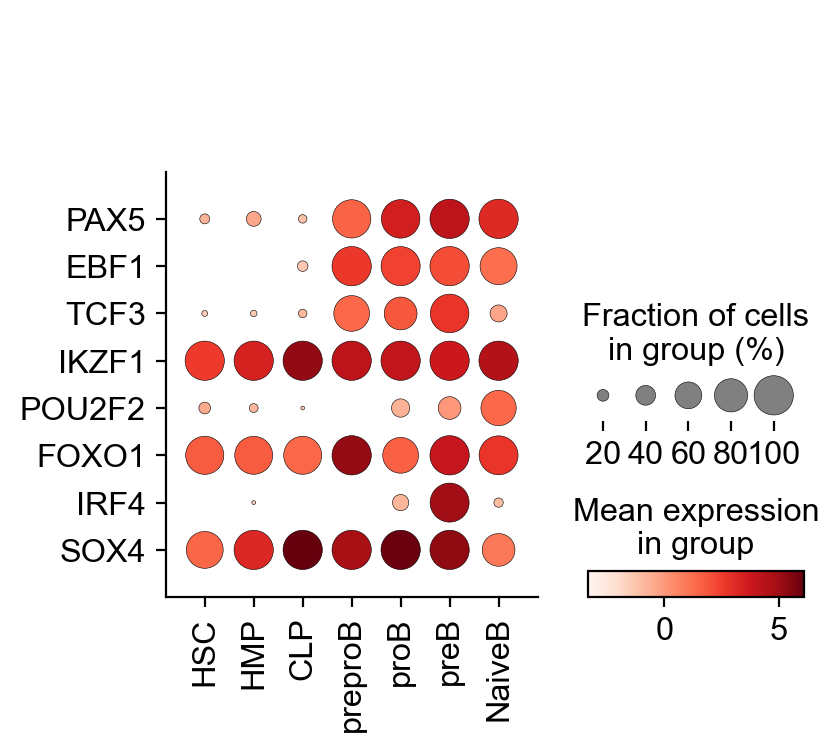

In [26]:
sc.pl.dotplot(
    gdata["GRN"],
    var_names=key_TFs,
    groupby="celltype",
    use_raw=False,
    swap_axes=True,
)

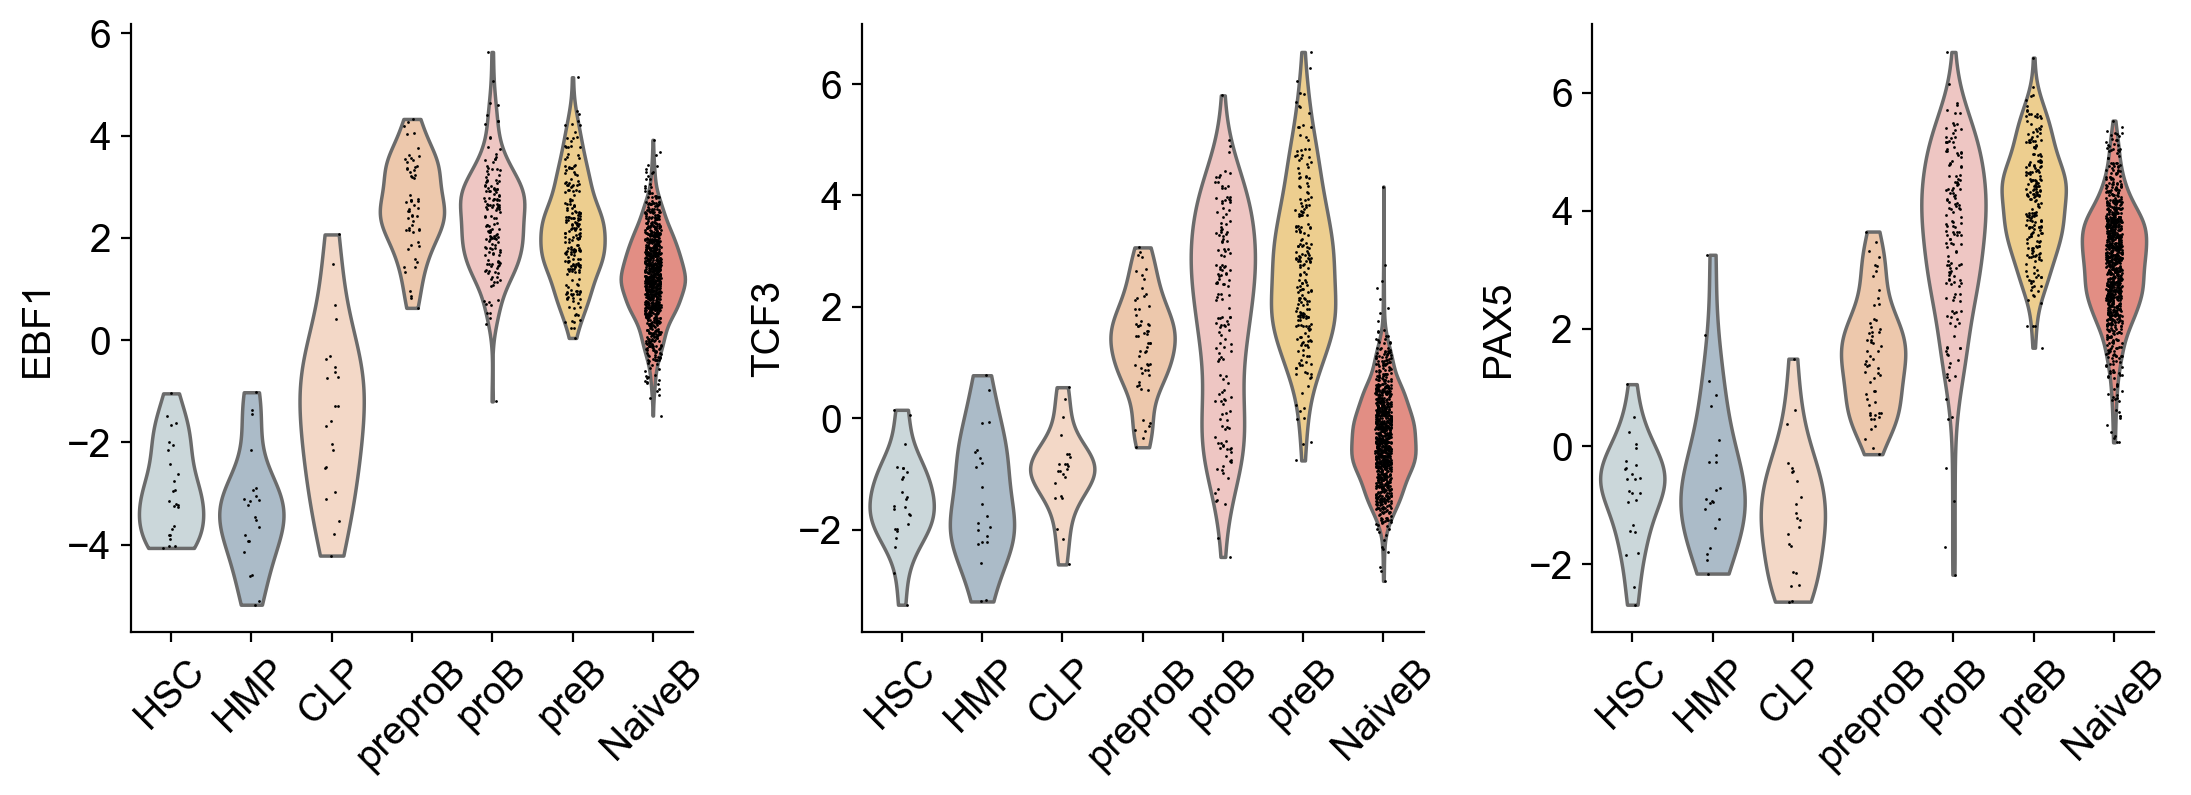

In [31]:
sc.pl.violin(
    gdata["GRN"],
    keys=["EBF1", "TCF3", "PAX5"],
    groupby="celltype",
    use_raw=False,
    rotation=45,
    multi_panel=True
)

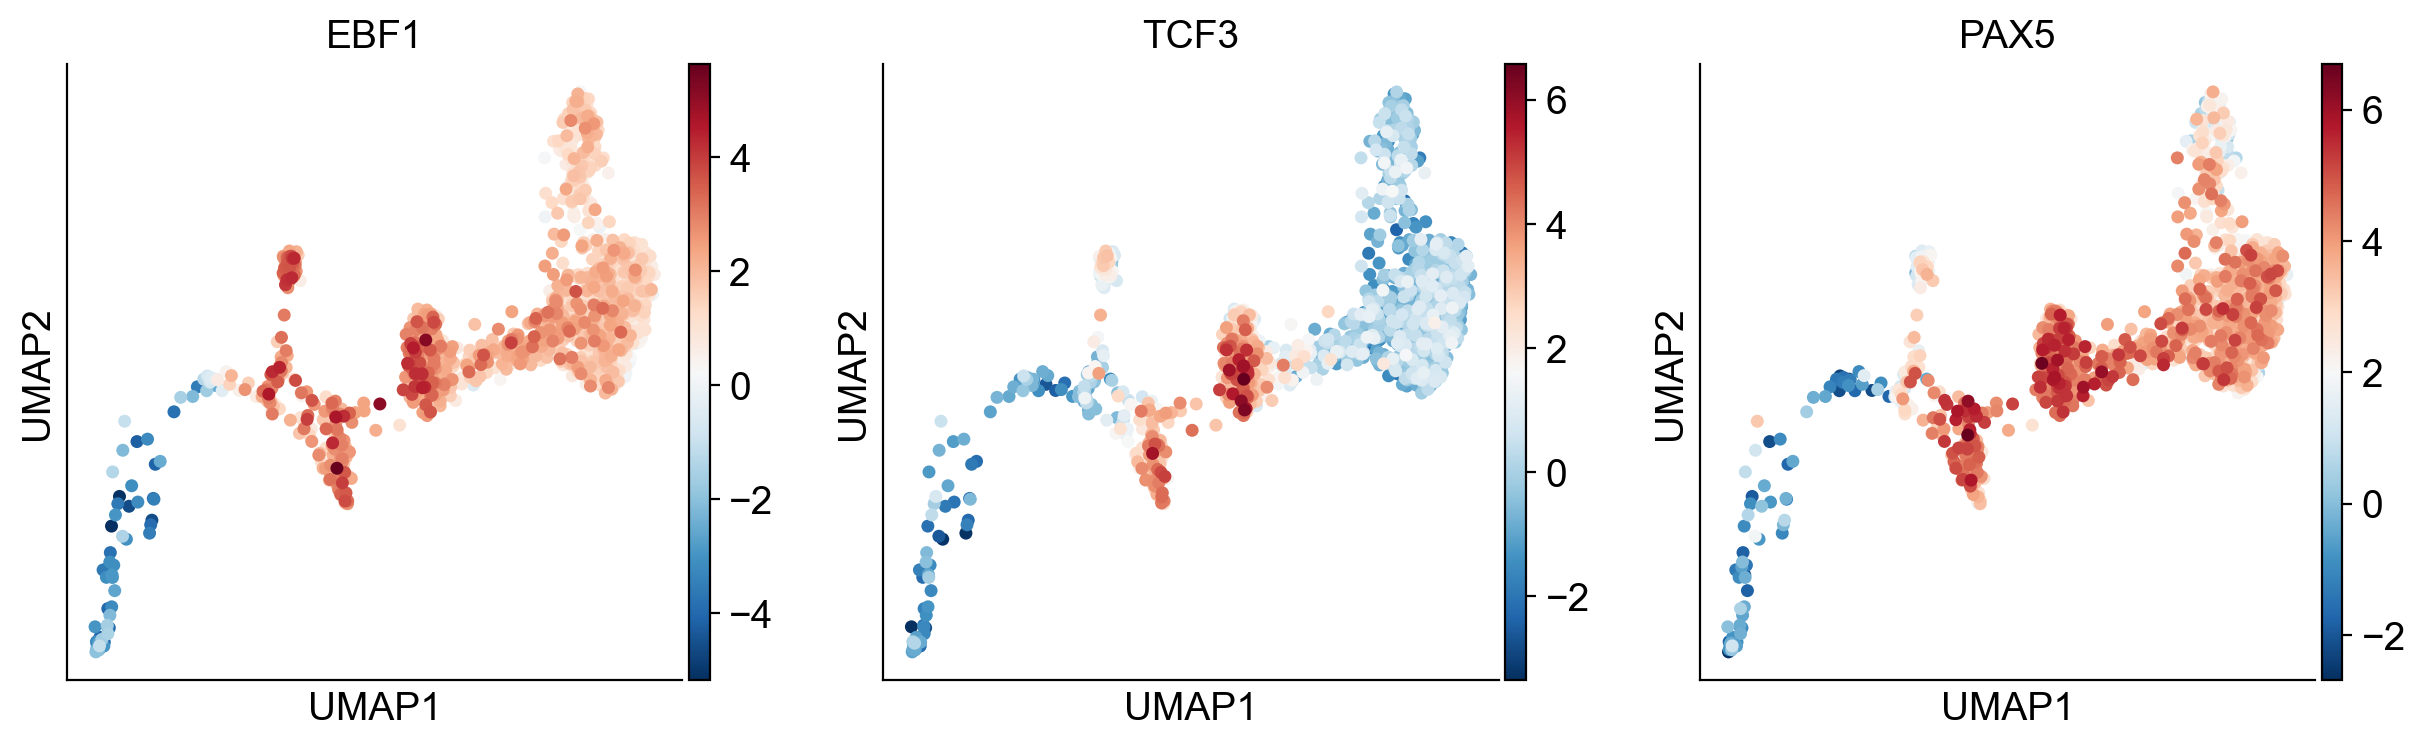

In [41]:
sc.pl.umap(
    gdata["GRN"],
    color=["EBF1", "TCF3", "PAX5"],
    use_raw=False,
    cmap="RdBu_r",
    ncols=3,
)

Finally, `scm.pl.trendplot` offers a powerful way to directly compare the dynamics of a TF's regulatory activity (from gdata["GRN"]) against its own mRNA expression (from gdata["RNA"]) along the differentiation pseudotime.

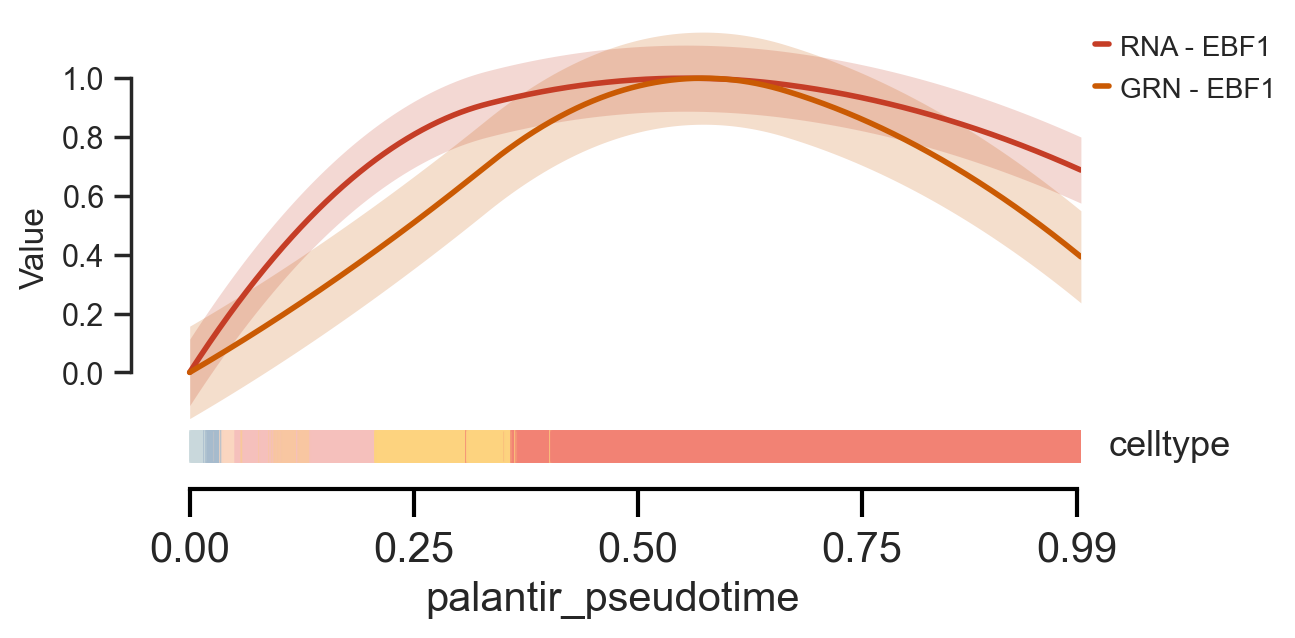

<Axes: xlabel='palantir_pseudotime', ylabel='Value'>

In [39]:
scm.pl.trendplot(
    gdata,
    var_dict={"EBF1": [("RNA", "log1p_norm"), ("GRN", None)]},
    normalize = True,
    sortby = "palantir_pseudotime",
    col_color = ["celltype"],
    palette=["#C53D26","#CA5A03"],
    figsize=(6, 3),
    dpi=100,
    n_splines=5,
    show_tkey=False,
    show_stds=True
)

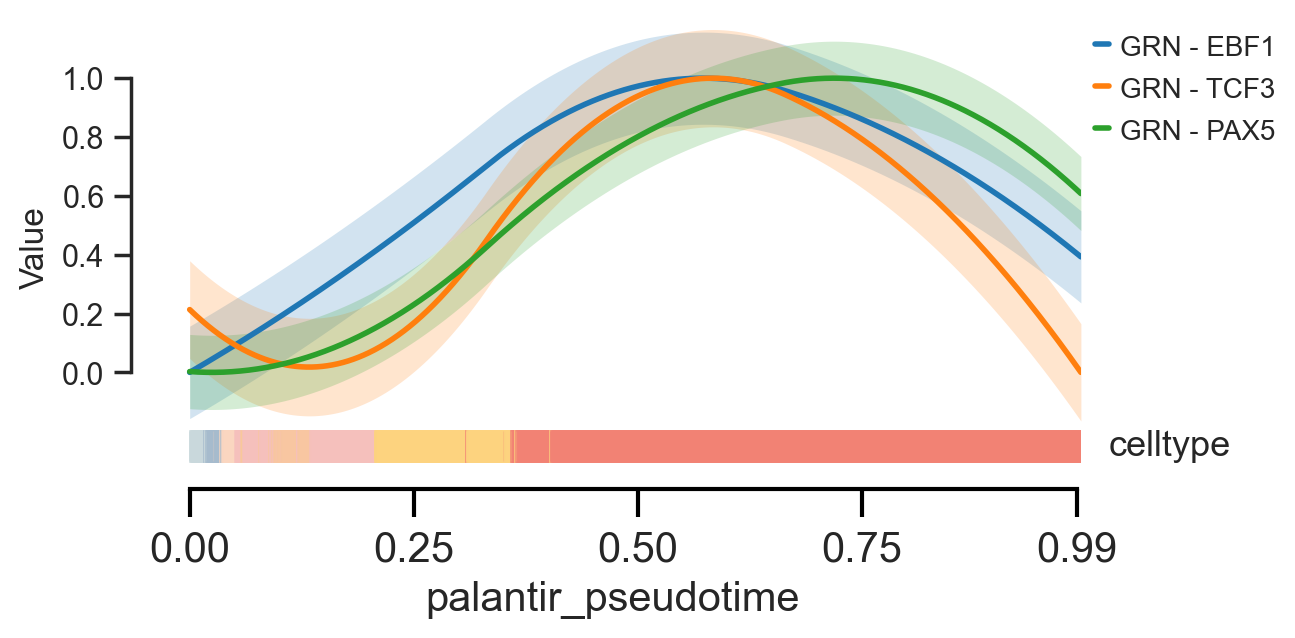

<Axes: xlabel='palantir_pseudotime', ylabel='Value'>

In [40]:
scm.pl.trendplot(
    gdata,
    var_dict={ 
                "EBF1": [("GRN", None)],
                "TCF3": [("GRN", None)],
                "PAX5": [("GRN", None)]
            },
            
    normalize = True,
    sortby = "palantir_pseudotime",
    col_color = ["celltype"],
    figsize=(6, 3),
    dpi=100,
    n_splines=5,
    show_tkey=False,
    show_stds=True
)

## Network Analysis

Beyond individual TF activities, `scMagnify` provides tools to analyze the topology of the entire inferred GRN. We can use graph-based network metrics to identify the most central and influential regulators in the system.

The function {py:func}`~scmagnify.tl.get_network_score` calculates a suite of standard centrality measures for each TF based on the inferred network structure. This includes:
* **Degree Centrality** (total, in, and out)
* **Betweenness Centrality**
* **Closeness Centrality**
* **PageRank**
* **Number of Targets** (`n_targets`)

These scores are computed and stored in `gdata["GRN"].varm["network_score"]`.

In [42]:
gdata = scm.tl.get_network_score(gdata)

In [43]:
gdata["GRN"].varm["network_score"].head()

,degree_centrality,degree_centrality(in),degree_centrality(out),betweenness_centrality,closeness_centrality,pagerank,n_targets
AHR,0.032468,0.003418,0.029050,0.000007,0.018391,0.000335,85
ARID5B,0.174641,0.017088,0.157553,0.000225,0.023396,0.000350,461
ATF2,0.161312,0.004101,0.157211,0.000051,0.018300,0.000336,460
BACH1,0.305878,0.011620,0.294258,0.000353,0.021123,0.000348,861
BACH2,0.440533,0.017430,0.423103,0.000646,0.023396,0.000351,1238


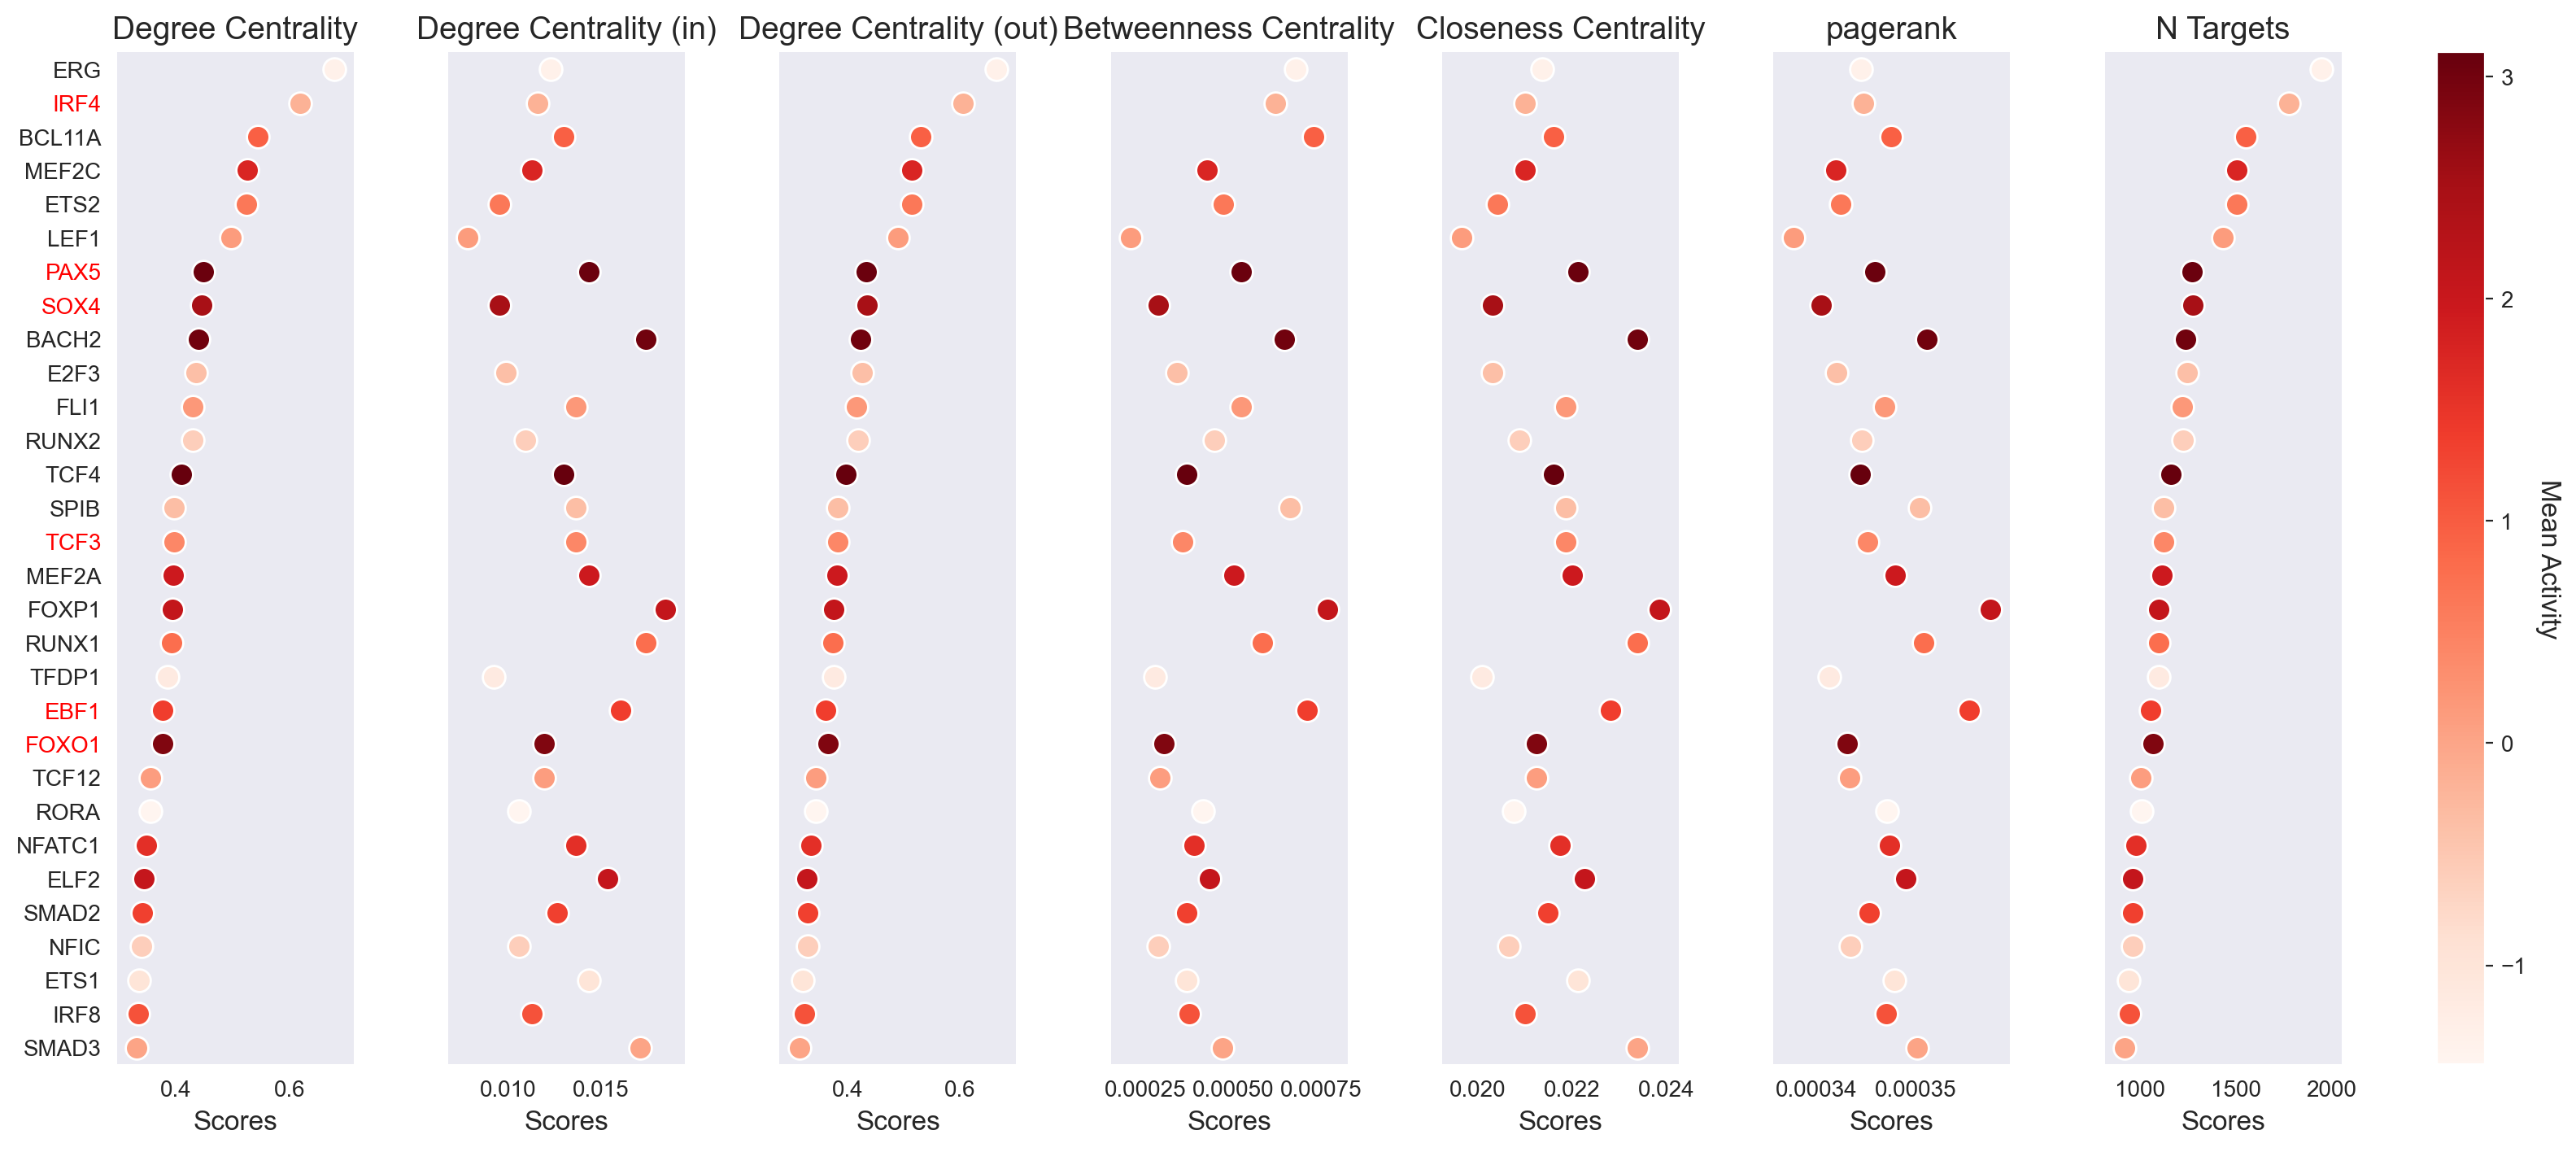

In [44]:
scm.pl.stripplot(
    gdata, 
    sortby="degree_centrality", 
    selected_genes=key_TFs
)

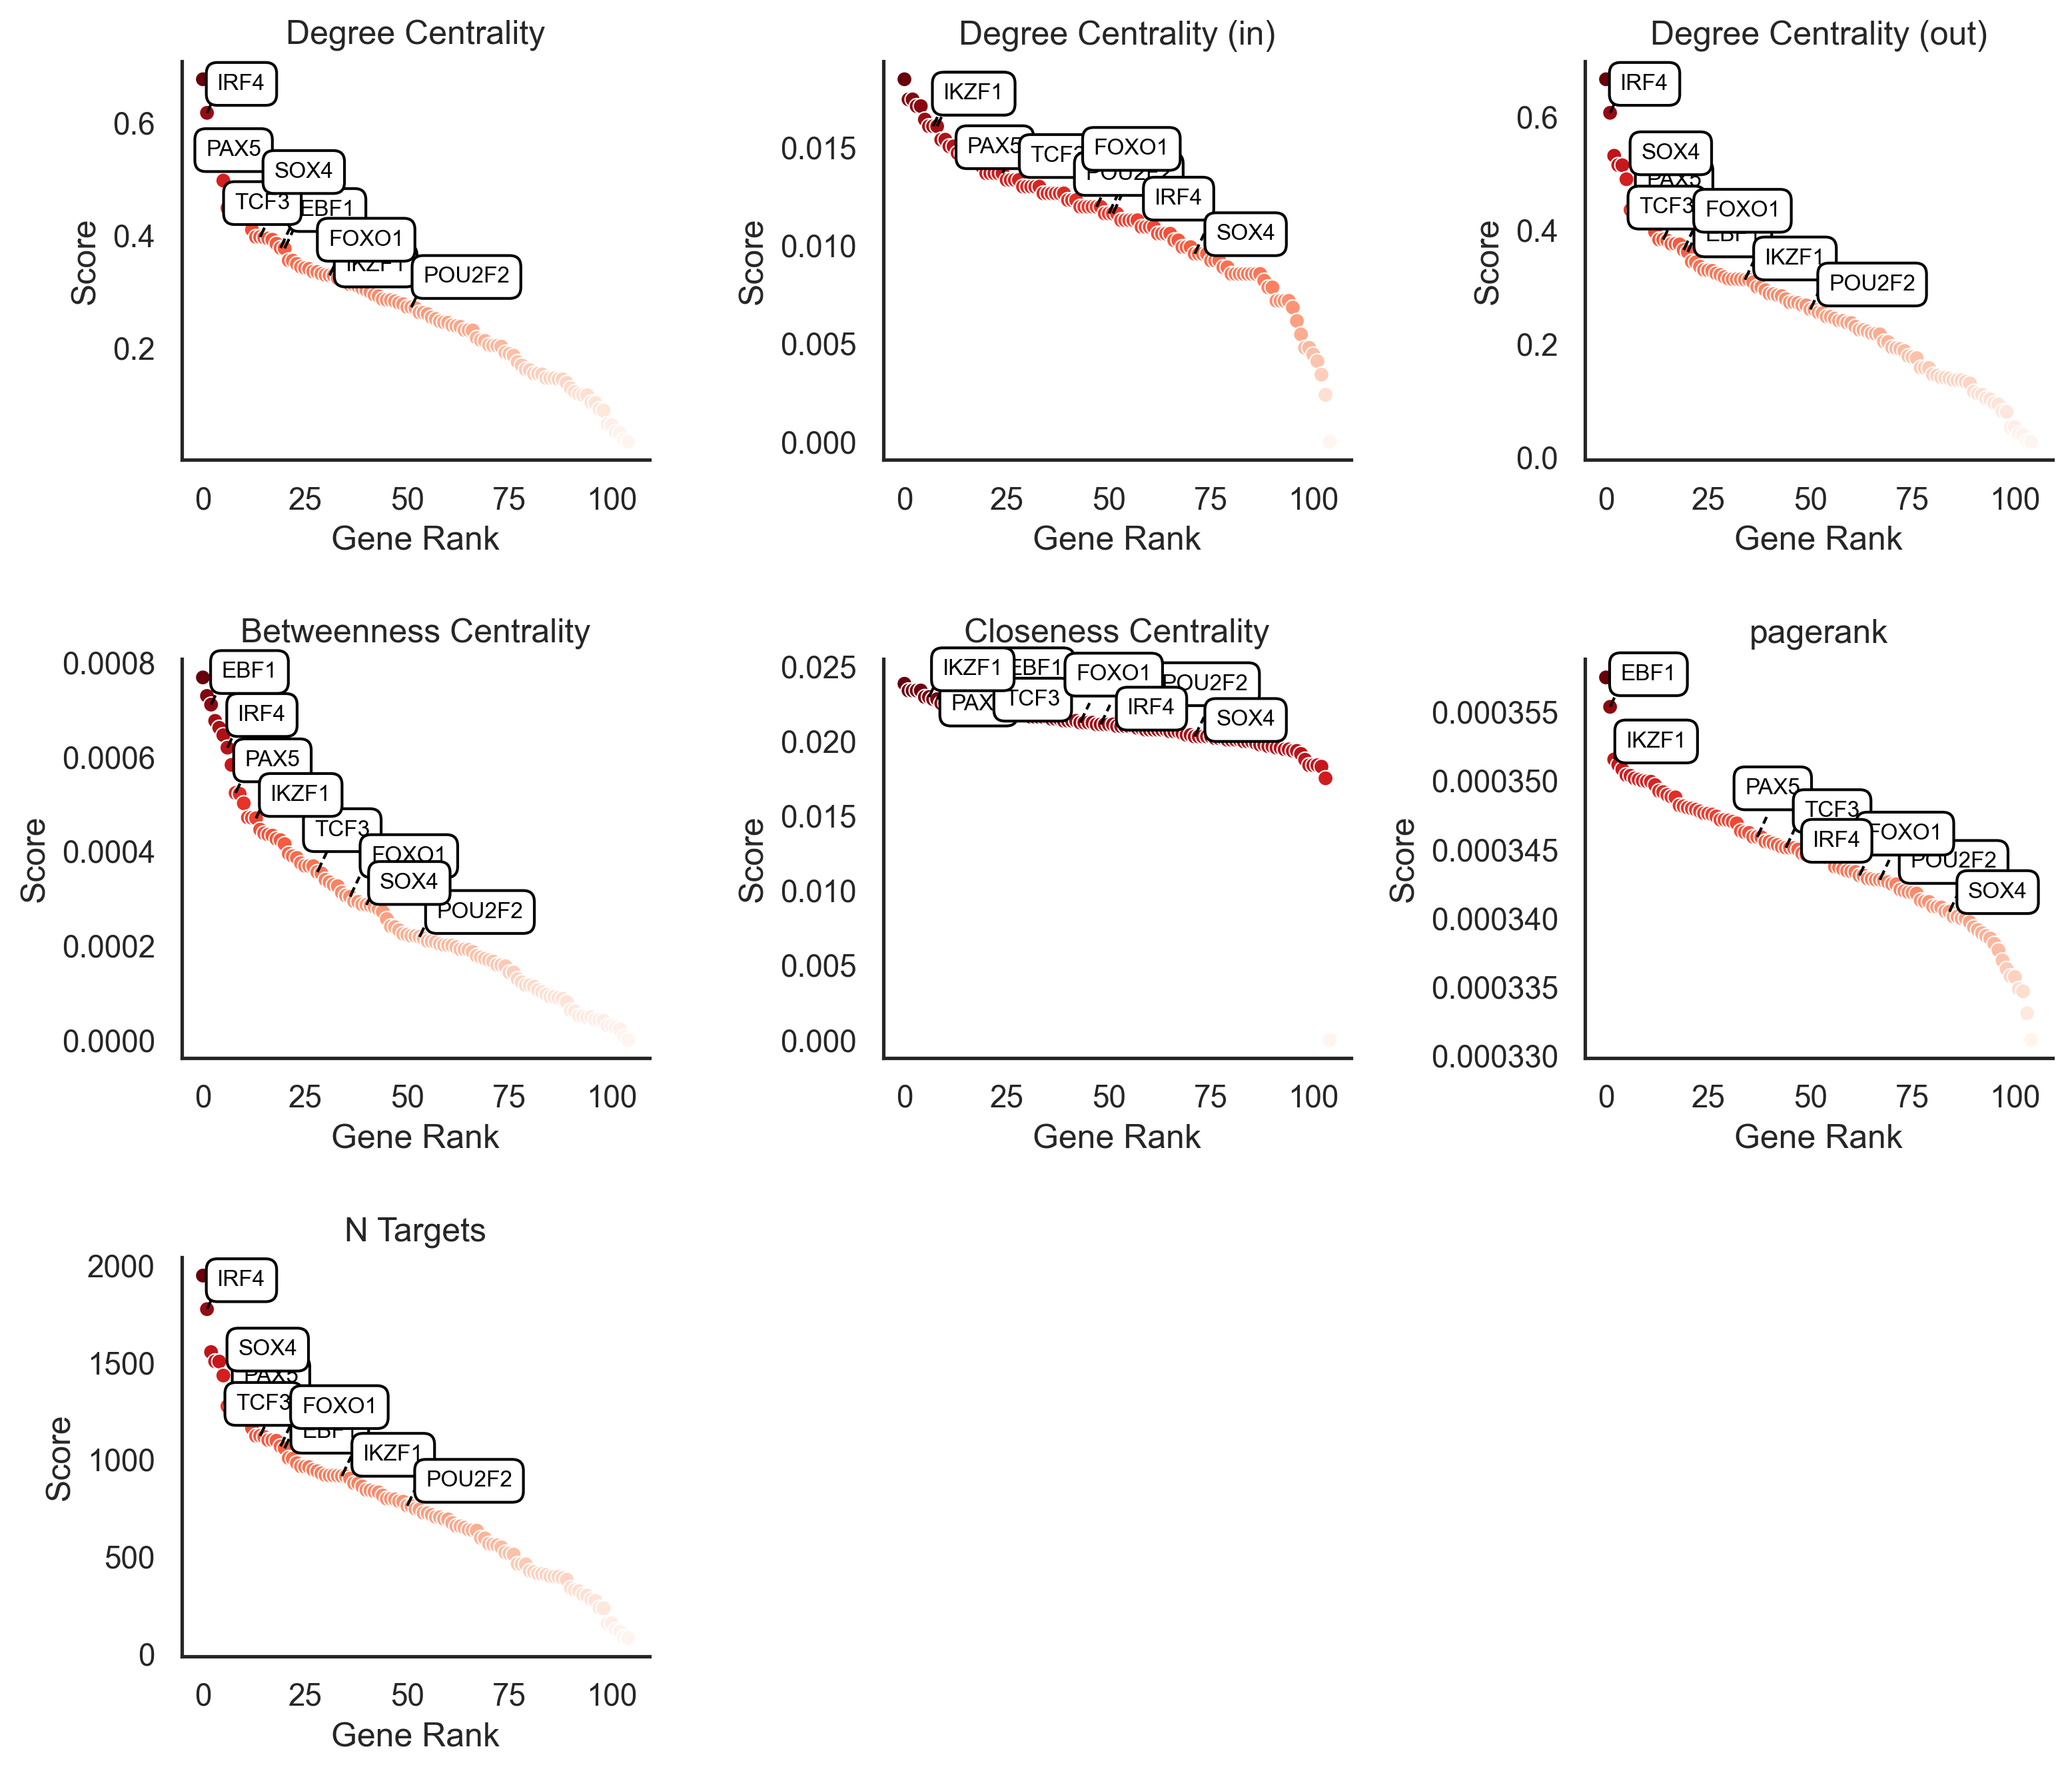

In [51]:
scm.pl.rankplot(
    gdata, 
    selected_genes=key_TFs, 
    show=True
)

### Save the data

In [ ]:
gdata.write(os.path.join(settings.data_dir, "gdata_tcelldep-bm_03_NaiveB.h5mu"))

## Closing matters

### What's next?

In this tutorial, you learned how to infer the multi-scale GRN using `scm.MAGNI`. This produced a `GRNMuData` object containing the inferred network, TF regulatory activities, and network centrality scores, allowing you to identify key individual regulators.

However, TFs often work in combination. For the next steps, we recommend the following:

-   Proceed to the final tutorial on **[RegFactor Decomposition and Enrichment](./Tutorial_4_RegFactor_Decomposition.md)**. This analysis will allow you to move beyond individual TFs and discover combinatorial "modules" of co-regulating TFs using tensor decomposition.
-   Refer to the {doc}`API <scmagnify>` to explore the available parameter values that can be used to customize these computations for your data.

If you encounter any bugs or have suggestions for new features, please open an [issue](https://github.com/your_repo_link/issues). For general questions, please post on the [scverse discourse](https://discourse.scverse.org/) or contact us at chenxufeng2022@sinh.ac.cn.


### Package versions

In [56]:
import session_info 
session_info.show()